# Node prediction

1. Complete a basic node prediction with GNN (predict vmiles with pop )

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
import statsmodels.api as sm
import copy

/usr/local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [41]:
import networkx as nx

In [2]:
import torch
from torch_geometric.data import Data

In [3]:
# read files
# read files
flow_16_acs_ma=gpd.read_file('../../data/processed_small_data/flow_16_acs_MA_shp.geojson')
flow_20_march_week4_ma=gpd.read_file('../../data/processed_small_data/flow_20_march_week4_MA_shp.geojson')
us_tract_ma=gpd.read_file('../../data/processed_small_data/us_tract_MA_shp.geojson')


In [4]:
# 
print(flow_16_acs_ma.shape)
print(flow_20_march_week4_ma.shape)
print(us_tract_ma.shape)

(101633, 13)
(63848, 10)
(1459, 66)


In [6]:
flow_16_acs_ma.head()

,Ofips,Dfips,Ostfips,Octfips,Otrfips,Dstfips,Dctfips,Dtrfips,Flow,Moe,LenKM,ESTDIVMOE,geometry
0,25015820400,25015820400,25,15,820400,25,15,820400,2505,391,0.0,6.41,"LINESTRING (1900558.820 2390415.541, 1900558.8..."
1,25003925100,25003925100,25,3,925100,25,3,925100,2050,317,0.0,6.47,"LINESTRING (1840991.191 2354932.119, 1840991.1..."
2,25021404400,25021404400,25,21,404400,25,21,404400,1915,390,0.0,4.91,"LINESTRING (2000840.403 2404838.904, 2000840.4..."
3,25001010100,25001010100,25,1,10100,25,1,10100,1540,246,0.0,6.26,"LINESTRING (2094693.021 2403721.152, 2094693.0..."
4,25003914100,25003914100,25,3,914100,25,3,914100,1215,256,0.0,4.75,"LINESTRING (1847368.343 2366845.098, 1847368.3..."


In [7]:
flow_20_march_week4_ma.head()

,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date_range,visitor_flows,pop_flows,geometry
0,25001012700,25017342400,-70.341803,41.645342,-71.062198,42.398850,03/23/20 - 03/29/20,4,109.0,"LINESTRING (2095835.909 2355892.236, 2016504.4..."
1,25001012700,25001015300,-70.341803,41.645342,-70.290085,41.673588,03/23/20 - 03/29/20,215,5883.0,"LINESTRING (2095835.909 2355892.236, 2099112.2..."
2,25001012700,25001010400,-70.341803,41.645342,-69.983433,41.757063,03/23/20 - 03/29/20,20,547.0,"LINESTRING (2095835.909 2355892.236, 2120999.0..."
3,25001012700,25023545100,-70.341803,41.645342,-70.754009,41.768764,03/23/20 - 03/29/20,4,109.0,"LINESTRING (2095835.909 2355892.236, 2059342.3..."
4,25001012700,25025081001,-70.341803,41.645342,-71.106830,42.334567,03/23/20 - 03/29/20,4,109.0,"LINESTRING (2095835.909 2355892.236, 2014839.6..."


In [38]:
us_tract_ma

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,pct_worker_2_more,binge,bphigh,chd,diabetes,obesity,lpa,total_pop_cdc,geometry,discrete_est_vtrp
0,0,25,027,724100,25027724100,7241,Census Tract 7241,G5020,S,53034202,...,37.54,18.0,33.5,6.9,9.4,30.7,25.3,3701,"POLYGON ((-72.21782 42.27018, -72.21765 42.270...",1.0
1,1,25,027,759100,25027759100,7591,Census Tract 7591,G5020,S,25570219,...,43.34,20.5,28.9,5.8,8.3,31.1,23.4,2183,"POLYGON ((-72.07888 42.21475, -72.07880 42.214...",1.0
2,2,25,025,091300,25025091300,913,Census Tract 913,G5020,S,262560,...,37.00,18.8,29.1,6.2,11.6,28.0,32.3,2499,"POLYGON ((-71.07220 42.32136, -71.07174 42.321...",0.0
3,3,25,025,110501,25025110501,1105.01,Census Tract 1105.01,G5020,S,647837,...,45.67,22.8,24.8,4.8,7.1,20.6,19.2,3253,"POLYGON ((-71.14777 42.28599, -71.14739 42.286...",0.0
4,4,25,025,030500,25025030500,305,Census Tract 305,G5020,S,193673,...,31.83,29.1,16.0,2.8,3.8,15.5,12.5,2538,"POLYGON ((-71.05979 42.36877, -71.05883 42.369...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,1454,25,005,610203,25005610203,6102.03,Census Tract 6102.03,G5020,S,14218546,...,56.58,22.4,25.6,4.5,6.4,26.0,17.3,6883,"POLYGON ((-71.22550 42.01822, -71.22373 42.018...",1.0
1422,1455,25,005,611202,25005611202,6112.02,Census Tract 6112.02,G5020,S,16516218,...,46.00,21.8,27.9,5.5,7.6,27.7,21.0,6396,"POLYGON ((-71.25929 41.97422, -71.24939 41.977...",1.0
1423,1456,25,005,611102,25005611102,6111.02,Census Tract 6111.02,G5020,S,17393046,...,50.35,25.4,20.6,3.7,5.4,24.6,18.2,5047,"POLYGON ((-71.21047 41.95602, -71.20995 41.956...",1.0
1424,1457,25,005,653204,25005653204,6532.04,Census Tract 6532.04,G5020,S,12475485,...,43.01,20.5,30.8,6.7,9.1,28.6,24.4,3214,"POLYGON ((-71.00314 41.60654, -71.00313 41.606...",1.0


In [37]:
# drop any na.
us_tract_ma=us_tract_ma.dropna(how='any')
us_tract_ma.reset_index(inplace = True)
print(us_tract_ma.shape)

(1426, 68)


In [9]:
us_tract_ma.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'layer', 'path',
       'geoid_x', 'pop', 'households', 'male', 'male_ratio', 'female',
       'female_ratio', 'median_age', 'white', 'black', 'asian', 'other_race',
       'white_ratio', 'black_ratio', 'asian_ratio', 'other_race_ratio',
       'income', 'pop_no_inc', 'pop_inc_10k', 'pop_inc_10k_15k',
       'pop_inc_15k_25k', 'pop_inc_25k_35k', 'pop_inc_35k_50k',
       'pop_inc_50k_65k', 'pop_inc_65k_75k', 'pop_inc_75k', 'geoid_y',
       'est_pmiles', 'est_ptrp', 'est_vmiles', 'est_vtrp', 'total_pop_bts',
       'households_bts', 'median_hh_inc_bts', 'hh_veh_0', 'hh_veh_1',
       'hh_veh_2_more', 'pct_veh_0', 'pct_veh_1', 'pct_veh_2_more',
       'hh_worker_1', 'pct_worker_1', 'hh_worker_2_more', 'pct_worker_2_more',
       'binge', 'bphigh', 'chd', 'diabetes', 'obesity', 'lpa', 'total_pop_cdc',
       'geometry'],
      dtype='object')

# Prepare data sets

In [16]:
# target
# 'pop', 'income', 'male', 'est_vtrp'
# y
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
discrete_est_vtrp = est.fit_transform(us_tract_ma['est_vtrp'].values[:, np.newaxis])
us_tract_ma['discrete_est_vtrp'] = discrete_est_vtrp # this is y.
y = copy.copy(discrete_est_vtrp)
y_torch = torch.LongTensor(discrete_est_vtrp).squeeze()
y_torch

tensor([1, 1, 0,  ..., 1, 1, 1])

In [23]:
# X
X = us_tract_ma[['pop', 'income', 'male']].values
from sklearn.preprocessing import normalize
X = normalize(X, norm='max', axis=0) # normalize to zero and one when norm='max'
X_torch = torch.FloatTensor(X)
X_torch

tensor([[0.1930, 0.6000, 0.3225],
        [0.1615, 0.6146, 0.1943],
        [0.1340, 0.3853, 0.2315],
        ...,
        [0.3165, 0.4548, 0.4427],
        [0.1445, 0.6271, 0.2952],
        [0.2010, 0.5623, 0.4489]])

(array([  8.,  39.,  95., 173., 246., 370., 347., 119.,  23.,   6.]),
 array([0.15161655, 0.2364549 , 0.32129324, 0.40613159, 0.49096993,
        0.57580828, 0.66064662, 0.74548497, 0.83032331, 0.91516166,
        1.        ]),
 <a list of 10 Patch objects>)

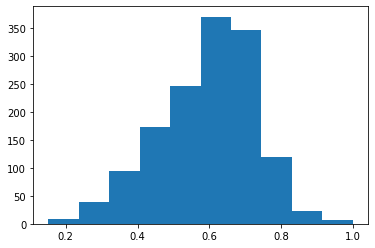

In [24]:
plt.hist(X[:,1])

In [49]:
# prepare edge index using flow_20_march_week4_ma
node_dic = dict(zip(us_tract_ma.GEOID, us_tract_ma.index))
node_dic

{'25027724100': 0,
 '25027759100': 1,
 '25025091300': 2,
 '25025110501': 3,
 '25025030500': 4,
 '25025010500': 5,
 '25017321200': 6,
 '25027710200': 7,
 '25027760100': 8,
 '25013812404': 9,
 '25013812201': 10,
 '25017383700': 11,
 '25017383800': 12,
 '25025140201': 13,
 '25025082100': 14,
 '25013801902': 15,
 '25025070900': 16,
 '25025050500': 17,
 '25025101101': 18,
 '25025170300': 19,
 '25025180500': 20,
 '25025120600': 21,
 '25025091700': 22,
 '25025070200': 23,
 '25025030100': 24,
 '25017385100': 25,
 '25017322100': 26,
 '25017339400': 27,
 '25023507103': 28,
 '25023510100': 29,
 '25023510200': 30,
 '25023510501': 31,
 '25023510502': 32,
 '25005645101': 33,
 '25005650101': 34,
 '25005650102': 35,
 '25005650201': 36,
 '25005650202': 37,
 '25023510503': 38,
 '25023510600': 39,
 '25023510700': 40,
 '25023510800': 41,
 '25023510900': 42,
 '25023511000': 43,
 '25023511100': 44,
 '25013801604': 45,
 '25023501202': 46,
 '25023545200': 47,
 '25023506102': 48,
 '25023504101': 49,
 '25023508

In [48]:
# edge network
flow_20_march_week4_ma_nx = nx.from_pandas_edgelist(flow_20_march_week4_ma, 'geoid_o', 'geoid_d', edge_attr='pop_flows')
flow_20_march_week4_ma_nx.edges()

EdgeView([('25001012700', '25017342400'), ('25001012700', '25001015300'), ('25001012700', '25001010400'), ('25001012700', '25023545100'), ('25001012700', '25025081001'), ('25001012700', '25005651200'), ('25001012700', '25013811700'), ('25001012700', '25001013800'), ('25001012700', '25001011500'), ('25001012700', '25005631700'), ('25001012700', '25001012002'), ('25001012700', '25001010700'), ('25001012700', '25001014700'), ('25001012700', '25017336402'), ('25001012700', '25001014800'), ('25001012700', '25001012200'), ('25001012700', '25005631500'), ('25001012700', '25001012602'), ('25001012700', '25025091100'), ('25001012700', '25001012001'), ('25001012700', '25001012800'), ('25001012700', '25001013600'), ('25001012700', '25001012102'), ('25001012700', '25001012502'), ('25001012700', '25001012700'), ('25001012700', '25001011400'), ('25001012700', '25001015100'), ('25001012700', '25023530500'), ('25001012700', '25001011700'), ('25001012700', '25001012101'), ('25001012700', '25021422302')

In [56]:
### 
edge_list = []

for edge_pair in list(flow_20_march_week4_ma_nx.edges()):
    try:
        if edge_pair[0] != edge_pair[1]: # remove the self-loops
            new_pair = [node_dic[edge_pair[0]],node_dic[edge_pair[1]]]
            edge_list.append(new_pair)
        else:
            continue
#         print(new_pair)
    except KeyError: # the edge df has more node indicators than the node df. 
        continue

edge_index = np.array(edge_list).transpose()
edge_index = torch.LongTensor(edge_index)
edge_index


tensor([[ 723,  723,  723,  ..., 1239,  551,  545],
        [ 412,  192,  697,  ...,  103,  545, 1383]])

In [58]:
# create the data and add masks for GNN regression
data = Data(x=X_torch, y=y_torch, edge_index = edge_index)

train_mask = np.random.choice([True, False], size = 1426, p = [0.8, 0.2]) # 80% training and 20% testing.
test_mask = np.logical_not(train_mask)

data.train_mask = torch.BoolTensor(train_mask)
data.test_mask = torch.BoolTensor(test_mask)
data


Data(edge_index=[2, 51527], test_mask=[1426], train_mask=[1426], x=[1426, 3], y=[1426])

# Baseline linear reg

In [30]:
mod = sm.Logit(y, X)
res = mod.fit()
print(res.summary())
print(res.pred_table())
print('accuracy is: ', (res.pred_table()[0,0]+ res.pred_table()[1,1])/np.sum(res.pred_table()))

Optimization terminated successfully.
         Current function value: 0.681270
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1426
Model:                          Logit   Df Residuals:                     1423
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Apr 2021   Pseudo R-squ.:                 0.01713
Time:                        19:45:16   Log-Likelihood:                -971.49
converged:                       True   LL-Null:                       -988.42
Covariance Type:            nonrobust   LLR p-value:                 4.434e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.2184      1.056      3.993      0.000       2.148       6.289
x2            -0.6281      0.

# Baseline GNN

In [59]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [60]:
# a naive GNN
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(3, 15)
        self.conv2 = GCNConv(15, 2)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim = 1)
        

In [61]:
# 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [62]:
# train
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # evaluate 
    if epoch%20 == 0:
        _, pred = model(data).max(dim=1)
        train_correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
        train_acc = train_correct / int(data.train_mask.sum())
        test_correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
        test_acc = test_correct / int(data.test_mask.sum())
        print('Epoch: {}, Training Accuracy: {:.4f}'.format(epoch, train_acc))
        print('Epoch: {}, Testing Accuracy: {:.4f}'.format(epoch, test_acc))
        

Epoch: 0, Training Accuracy: 0.5130
Epoch: 0, Testing Accuracy: 0.5147
Epoch: 20, Training Accuracy: 0.5251
Epoch: 20, Testing Accuracy: 0.4779
Epoch: 40, Training Accuracy: 0.5217
Epoch: 40, Testing Accuracy: 0.4890
Epoch: 60, Training Accuracy: 0.5537
Epoch: 60, Testing Accuracy: 0.5368
Epoch: 80, Training Accuracy: 0.5589
Epoch: 80, Testing Accuracy: 0.5551
Epoch: 100, Training Accuracy: 0.5598
Epoch: 100, Testing Accuracy: 0.5588
Epoch: 120, Training Accuracy: 0.5901
Epoch: 120, Testing Accuracy: 0.5478
Epoch: 140, Training Accuracy: 0.5893
Epoch: 140, Testing Accuracy: 0.5699
Epoch: 160, Training Accuracy: 0.5971
Epoch: 160, Testing Accuracy: 0.5588
Epoch: 180, Training Accuracy: 0.5893
Epoch: 180, Testing Accuracy: 0.5699
